In [1]:
import os
import sys

if os.path.basename(os.getcwd()) == "testing":
    os.chdir(os.path.dirname(os.getcwd()))
    sys.path.append(os.getcwd())

import struct

import constriction
import lossless.component.core.arm as arm
import lossless.component.core.arm_image as arm_image
import lossless.util.color_transform as color_transform
import matplotlib.pyplot as plt
import numpy as np
import torch
from lossless.component.coolchic import CoolChicEncoder, CoolChicEncoderParameter
from lossless.component.types import POSSIBLE_ENCODING_DISTRIBUTIONS
from lossless.training.manager import ImageEncoderManager
from lossless.util.config import args
from lossless.util.distribution import (
    get_scale,
)
from lossless.util.image_loading import load_image_as_tensor
from lossless.util.parsecli import (
    change_n_out_synth,
    get_coolchic_param_from_args,
    get_manager_from_args,
)
from till_encode import _laplace_cdf, _logistic_cdf, calculate_probability_distribution

np.set_printoptions(precision=16)
from _io import BufferedReader
from lossless.component.core.quantizer import quantize


class StopExecution(Exception):
    def _render_traceback_(self):
        return []


class MonochromeBitdepths(color_transform.ColorBitdepths):
    def __init__(self) -> None:
        self.bitdepths = [8]
        self.scaling_factors = [255]
        self.bins = [256]
        self.ranges_int = [[0, 255]]


def plot_image_by_channels(image_tensor: torch.Tensor):
    image_np = image_tensor[0].permute(1, 2, 0).cpu().numpy()
    num_channels = image_np.shape[2]
    fig, axes = plt.subplots(1, num_channels, figsize=(5 * num_channels, 5))
    for i in range(num_channels):
        ax = axes[i]  # type: ignore
        im = ax.imshow(image_np[:, :, i], cmap="gray")
        ax.set_title(f"Channel {i+1}")
        ax.axis("off")
        fig.colorbar(im, ax=ax)
    plt.show()

Converting image to YCoCg color space


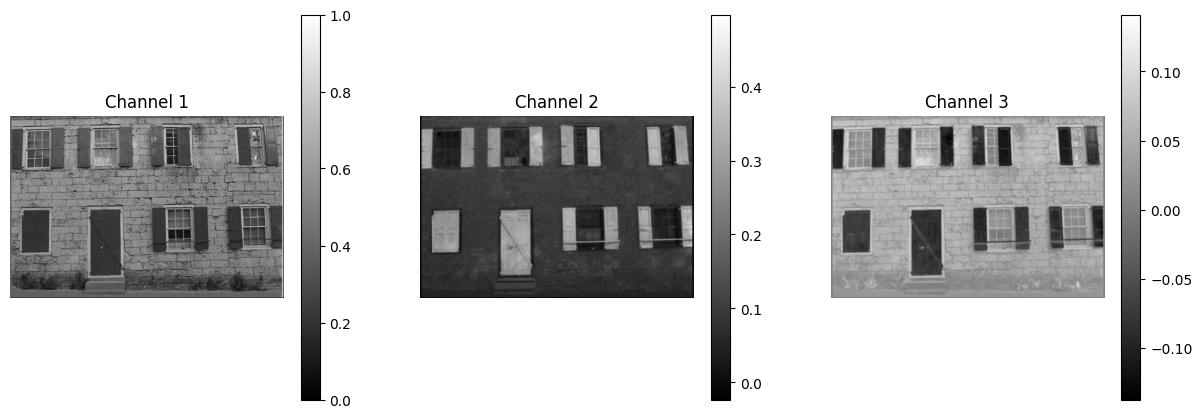

Loaded model from ../logs/full_runs/21_11_2025_YCoCg_with_fixed_colorregression/trained_models/2025_11_22__16_44_29__trained_coolchic_kodak_kodim01_img_rate_3.2631609439849854.pth


In [2]:
# ==========================================================================================
# LOAD IMAGE
# ==========================================================================================
color_space = "YCoCg"
use_image_arm = True
image_index = 0
im_path = f"../datasets/kodak/kodim{image_index+1:02d}.png"
im_tensor, c_bitdepths = load_image_as_tensor(
    im_path, device="cuda:0", color_space=color_space
)
plot_image_by_channels(im_tensor)
# ==========================================================================================
# LOAD PRESETS, COOLCHIC PARAMETERS
# ==========================================================================================
model_paths = os.listdir(
    "../logs/full_runs/21_11_2025_YCoCg_with_fixed_colorregression/trained_models"
)
model_paths = sorted(model_paths, key=lambda x: int(x.split("_kodim")[1].split("_")[0]))
args["pretrained_model_path"] = os.path.join(
    "../logs/full_runs/21_11_2025_YCoCg_with_fixed_colorregression/trained_models",
    model_paths[image_index],
)
image_encoder_manager = ImageEncoderManager(**get_manager_from_args(args))
encoder_param = CoolChicEncoderParameter(
    **get_coolchic_param_from_args(args, "lossless")
)
encoder_param.set_image_size((im_tensor.shape[2], im_tensor.shape[3]))
encoder_param.layers_synthesis = change_n_out_synth(
    encoder_param.layers_synthesis, args["output_dim_size"]
)
encoder_param.use_image_arm = use_image_arm
coolchic = CoolChicEncoder(param=encoder_param)
coolchic.to_device("cuda:0")
coolchic.load_state_dict(torch.load(args["pretrained_model_path"]))
print(f"Loaded model from {args['pretrained_model_path']}")

In [17]:
from torch._tensor import Tensor


class EncodeDecodeInterface:
    """This class provides unified interface for encoding and decoding with predictors irrespective of the underying data structure.

    The idea is to abstract the encoding and decoding logic from the specifics of what is being encoded - latents, image pixels, etc.
    """

    def __init__(self, data, predictor) -> None:
        self.data = data
        self.predictor = predictor

    def reset_iterators(self) -> None:
        raise NotImplementedError

    def advance_iterators(self) -> None:
        raise NotImplementedError

    def get_next_predictor_features(self) -> torch.Tensor:
        raise NotImplementedError

    def get_pdf_parameters(self, features: torch.Tensor) -> tuple:
        return self.predictor(features)

    def get_current_element(self):
        raise NotImplementedError

    def set_decoded_element(self, element) -> None:
        raise NotImplementedError

    def get_packing_parameters(self) -> bytes:
        raise NotImplementedError

    def set_packing_parameters(self, bitstream: BufferedReader) -> int:
        raise NotImplementedError

    def get_channel_idx(self) -> int:
        raise NotImplementedError


class LatentEncodeDecodeInterface(EncodeDecodeInterface):
    def __init__(self, data: list[torch.Tensor], predictor: arm.Arm) -> None:
        # latents are a list of tensors of shape [1, C, H, W]
        super().__init__(data, predictor)
        self.predictor = predictor
        self.current_latent_idx = 0
        self.current_spatial_pos = [0, 0, 0, 0]
        self.header_size = 4
        self.testing_stop = -1  # FIXME: temporary stop for testing

    def reset_iterators(self) -> None:
        self.current_latent_idx = 0
        self.current_spatial_pos = [0, 0, 0, 0]

    def _iterator_to_flat_index(self) -> int:
        latent_shape = self.data[self.current_latent_idx].shape
        flat_index = 0
        nested_multiplier = 1
        for index in range(len(self.current_spatial_pos) - 1, -1, -1):
            flat_index += self.current_spatial_pos[index] * nested_multiplier
            nested_multiplier *= latent_shape[index]
        return flat_index

    def _flat_index_to_iterator(self, flat_index: int) -> list[int]:
        latent_shape = self.data[self.current_latent_idx].shape
        res = [0, 0, 0, 0]
        for dim in range(len(self.current_spatial_pos) - 1, -1, -1):
            res[dim] = flat_index % latent_shape[dim]
            flat_index = flat_index // latent_shape[dim]
        return res

    def advance_iterators(self) -> None:
        if self.current_latent_idx >= len(self.data):
            raise StopIteration("All latents have been processed.")

        flat_index = self._iterator_to_flat_index()
        flat_index += 1
        # FIXME: temporary stop for testing
        if flat_index > self.testing_stop and self.testing_stop > 0:
            raise StopIteration("Partial stop for testing.")

        if flat_index >= self.data[self.current_latent_idx].numel():
            # move to next latent
            self.current_latent_idx += 1
            if self.current_latent_idx >= len(self.data):
                raise StopIteration("All latents have been processed.")
            self.current_spatial_pos = [0, 0, 0, 0]
            return
        # compute new spatial pos from flat index
        self.current_spatial_pos = self._flat_index_to_iterator(flat_index)

    def get_next_predictor_features(self) -> torch.Tensor:
        b, c, h, w = self.current_spatial_pos
        latent = self.data[self.current_latent_idx][b, c, :, :]
        context = self.predictor.get_neighbor_context(latent, h=h, w=w)
        return context

    def get_pdf_parameters(self, features: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # I assume that the features have shape [1, context_size]
        # print("Getting PDF parameters for latent index", self.current_latent_idx, "at position", self.current_spatial_pos)
        # print("Features:", features.dtype, features.shape, features)
        # raise StopExecution()
        mu, scale, log_scale = super().get_pdf_parameters(features)
        return mu[0], scale[0]

    def get_current_element(self):
        b, c, h, w = self.current_spatial_pos
        return self.data[self.current_latent_idx][b, c, h, w]

    def set_decoded_element(self, element) -> None:
        b, c, h, w = self.current_spatial_pos
        self.data[self.current_latent_idx][b, c, h, w] = element

    def get_packing_parameters(self) -> bytes:
        # this could
        total_elems = sum([latent.numel() for latent in self.data])
        return struct.pack("i", total_elems)

    def set_packing_parameters(self, bitstream: BufferedReader) -> int:
        header = bitstream.read(self.header_size)
        (total_elems,) = struct.unpack("i", header)
        # FIXME: currently we ignore the packing parameters for latents
        # as we assume fixed size latents known from the model
        return self.header_size

    def get_channel_idx(self) -> int:
        return self.current_spatial_pos[1]


class ImageEncodeDecodeInterface(EncodeDecodeInterface):
    def __init__(self, data: tuple, predictor: arm_image.ImageArm, batch_size: int) -> None:
        # raw image data is a tensor of shape [1, C, H, W]
        self.raw_image_data = data[0]
        self.raw_image_data_int = (self.raw_image_data * 255.0).to(torch.int16)
        # raw synth out is a tensor of shape [1, 9, H, W]
        self.raw_synth_out = data[1]
        self.predictor = predictor
        self.predictor = predictor
        self.current_spatial_pos = [0, 0, 0, 0] # order is B, C, H, W
        self.header_size = 12  # H, W, C
        self.cutoffs = [
            sum(predictor.synthesis_out_params_per_channel[:i])
            for i in range(len(predictor.synthesis_out_params_per_channel) + 1)
        ]
        self.testing_stop = -1  # FIXME: temporary stop for testing
        self.batch_size = batch_size

    def reset_iterators(self) -> None:
        self.current_spatial_pos = [0, 0, 0, 0]

    def _iterator_to_flat_index(self) -> int:
        # added in order: C -> W -> H -> B
        flat_index = self.current_spatial_pos[1] + \
            self.current_spatial_pos[3] * self.raw_image_data.shape[1] + \
            self.current_spatial_pos[2] * self.raw_image_data.shape[1] * self.raw_image_data.shape[3] + \
            self.current_spatial_pos[0] * self.raw_image_data.shape[1] * self.raw_image_data.shape[3] * self.raw_image_data.shape[2]
        return flat_index

    def _flat_index_to_iterator(self, flat_index: int) -> list[int]:
        res = [
            flat_index // (self.raw_image_data.shape[1] * self.raw_image_data.shape[3] * self.raw_image_data.shape[2]),
            flat_index % self.raw_image_data.shape[1],
            (flat_index // (self.raw_image_data.shape[1] * self.raw_image_data.shape[3])) % self.raw_image_data.shape[2],
            (flat_index // self.raw_image_data.shape[1]) % self.raw_image_data.shape[3],
        ]
        return res

    def advance_iterators(self) -> None:
        flat_index = self._iterator_to_flat_index()
        flat_index += 1
        if self.testing_stop > 0 and flat_index > self.testing_stop:
            raise StopIteration("Partial stop for testing.")
        if flat_index >= self.raw_image_data.numel():
            raise StopIteration("All pixels have been processed.")
        # compute new spatial pos from flat index
        self.current_spatial_pos = self._flat_index_to_iterator(flat_index)

    def get_next_predictor_features(self) -> Tensor:
        b, c, h, w = self.current_spatial_pos
        im_r = self.raw_image_data[b, 0, :, :]
        im_g = self.raw_image_data[b, 1, :, :]
        im_b = self.raw_image_data[b, 2, :, :]
        context_r = self.predictor.get_neighbor_context(im_r, h=h, w=w).flatten()
        context_g = self.predictor.get_neighbor_context(im_g, h=h, w=w).flatten()
        context_b = self.predictor.get_neighbor_context(im_b, h=h, w=w).flatten()
        # print("Context R:", context_r.shape)
        context = torch.stack([context_r, context_g, context_b], dim=1).reshape(1, -1)
        r_syn_o = self.raw_synth_out[b, :, h, w]
        im_known = self.raw_image_data[b, :c, h, w]
        full_feature = torch.cat([context, r_syn_o[None, :], im_known[None, :]], dim=1)
        
        random_balast = torch.randn((self.batch_size - 1, full_feature.shape[1]), device=full_feature.device)
        full_feature = torch.cat([full_feature, random_balast], dim=0)
        return full_feature

    def get_pdf_parameters(self, features: Tensor) -> tuple:
        current_channel = self.get_channel_idx()
        _, _, h, w = self.current_spatial_pos

        start_idx = self.cutoffs[current_channel] + self.predictor.context_size * 3
        end_idx = self.cutoffs[current_channel + 1] + self.predictor.context_size * 3
        relevant_raw_synth_out = features[:, start_idx:end_idx]

        image_arm_out = self.predictor.inference(
            features,
            relevant_raw_synth_out,
            current_channel,
        )[:1, :]  # take only the first in batch
        # print("PDF parameters for channel", current_channel, "at position", (h, w), "->", image_arm_out)
        if current_channel == 0:
            mu, log_scale = torch.chunk(image_arm_out, 2, dim=1)
            scale = get_scale(log_scale)
            return mu[0,0], scale[0,0]
        elif current_channel == 1:
            _mu, log_scale, alpha = torch.chunk(image_arm_out, 3, dim=1)
            mu = _mu + alpha * self.raw_image_data[0, current_channel - 1, h, w]
            scale = get_scale(log_scale)
            return mu[0,0], scale[0,0]
        elif current_channel == 2:
            _mu, log_scale, beta, gamma = torch.chunk(image_arm_out, 4, dim=1)
            mu = (
                _mu
                + beta * self.raw_image_data[0, current_channel - 2, h, w]
                + gamma * self.raw_image_data[0, current_channel - 1, h, w]
            )
            scale = get_scale(log_scale)
            return mu[0,0], scale[0,0]
        raise StopIteration(f"Cannot process channel index {current_channel}")

    def get_current_element(self):
        b, c, h, w = self.current_spatial_pos
        return self.raw_image_data_int[b, c, h, w]

    def set_decoded_element(self, element) -> None:
        b, c, h, w = self.current_spatial_pos
        self.raw_image_data_int[b, c, h, w] = element
        self.raw_image_data[b, c, h, w] = element / 255.0

    def get_packing_parameters(self) -> bytes:
        b, c, h, w = self.raw_image_data.shape
        return struct.pack("iii", h, w, c)

    def set_packing_parameters(self, bitstream: BufferedReader) -> int:
        header = bitstream.read(self.header_size)
        (h, w, c) = struct.unpack("iii", header)
        # FIXME: currently we ignore the packing parameters for the image
        # as we assume fixed size image known apriori. Technically the parameters are
        # in the stream so bpd measurement is unaffected.
        return self.header_size

    def get_channel_idx(self) -> int:
        return self.current_spatial_pos[1]

In [26]:
# ==========================================================================================
# DECODE WITH PREDICTOR
# ==========================================================================================


def encode_with_predictor(
    enc_dec_interface: EncodeDecodeInterface,
    ct: color_transform.ColorBitdepths = color_transform.YCoCgBitdepths(),
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
    output_path="./test-workdir/encoder_size_test/coolchic_encoded.binary",
):
    enc_dec_interface.reset_iterators()
    enc = constriction.stream.stack.AnsCoder()  # type: ignore
    bits_theoretical = 0

    with torch.no_grad():
        symbols_to_encode = []
        pixel_values = []
        prob_distributions = []
        while True:
            try:
                features = enc_dec_interface.get_next_predictor_features()
                mu, scale = enc_dec_interface.get_pdf_parameters(features)
                ch_ind = enc_dec_interface.get_channel_idx()
                # print("features:", features)
                print(f"Encoding pixel at position {enc_dec_interface.current_spatial_pos}")
                print("mu, scale:", mu.item(), scale.item())
                prob_distributions.append(
                    calculate_probability_distribution(
                        mu - ct.ranges_int[ch_ind][0] / ct.scaling_factors[ch_ind],
                        scale,
                        color_bitdepths=ct,
                        distribution=distribution,
                        channel_idx=ch_ind,
                    )
                )
                pixel_values.append(enc_dec_interface.get_current_element().int().item())
                # print(f"Pixel value to encode: {pixel_values[-1]}")
                symbols_to_encode.append(
                    enc_dec_interface.get_current_element().int().item() - ct.ranges_int[ch_ind][0]
                )
                bits_theoretical += -torch.log2(
                    prob_distributions[-1][symbols_to_encode[-1]]
                ).item()
                enc_dec_interface.advance_iterators()
            except StopIteration:
                break

        for symbol_index, symbol_to_encode, prob_distribution in zip(
            list(range(len(symbols_to_encode))),
            reversed(symbols_to_encode),
            reversed(prob_distributions),
        ):
            model = constriction.stream.model.Categorical(  # type: ignore
                prob_distribution.detach().cpu().numpy(), perfect=False
            )
            try:
                enc.encode_reverse(symbol_to_encode, model)
            except Exception as e:
                print(f"probability: {prob_distribution}")
                print(f"Error encoding symbol {symbol_to_encode} at index {symbol_index}")
                raise e

    bitstream = enc.get_compressed()
    bitstream.tofile(output_path)
    with open(output_path, "rb") as f:
        original_data = f.read()
    with open(output_path, "wb") as f:
        # Pack two 32-bit integers into binary
        f.write(enc_dec_interface.get_packing_parameters())
        f.write(original_data)

    print(f"Theoretical bits per sub pixel: {bits_theoretical/len(symbols_to_encode)}")

    return bitstream, symbols_to_encode, prob_distributions, pixel_values


def decode_quick_check(
    bitstream_path: str,
    prob_distributions: list[torch.Tensor],
    ct: color_transform.ColorBitdepths = color_transform.YCoCgBitdepths(),
    offset: int = 4,
):
    with open(bitstream_path, "rb") as f:
        header = f.read(offset)  # 3 integers * 4 bytes each
        num_symbols = struct.unpack("i" * (offset // 4), header)
    bitstream = np.fromfile(bitstream_path, dtype=np.uint32, offset=offset)
    dec = constriction.stream.stack.AnsCoder(bitstream)  # type: ignore

    decoded_symbols = []
    with torch.no_grad():
        for prob_distribution in prob_distributions:
            prob_array = prob_distribution.detach().cpu().flatten().numpy()
            model = constriction.stream.model.Categorical(prob_array, perfect=False)  # type: ignore
            decoded_char = torch.tensor(dec.decode(model, 1)[0]) + ct.ranges_int[0][0]
            decoded_symbols.append(decoded_char.item())
    return decoded_symbols


def decode_with_predictor(
    bitstream_path: str,
    enc_dec_interface: EncodeDecodeInterface,
    ct=color_transform.ColorBitdepths(),
    distribution: POSSIBLE_ENCODING_DISTRIBUTIONS = "logistic",
):
    enc_dec_interface.reset_iterators()
    with open(bitstream_path, "rb") as f:
        offset = enc_dec_interface.set_packing_parameters(f)
    bitstream = np.fromfile(bitstream_path, dtype=np.uint32, offset=offset)
    dec = constriction.stream.stack.AnsCoder(bitstream)  # type: ignore

    with torch.no_grad():
        symbols_decoded = []
        prob_distributions = []
        while True:
            try:
                features = enc_dec_interface.get_next_predictor_features()
                mu, scale = enc_dec_interface.get_pdf_parameters(features)
                ch_ind = enc_dec_interface.get_channel_idx()
                prob_distributions.append(
                    calculate_probability_distribution(
                        mu - ct.ranges_int[ch_ind][0] / ct.scaling_factors[ch_ind],
                        scale,
                        color_bitdepths=ct,
                        distribution=distribution,
                        channel_idx=ch_ind,
                    )
                )
                model = constriction.stream.model.Categorical(  # type: ignore
                    prob_distributions[-1].detach().cpu().numpy(), perfect=False
                )
                symbols_decoded.append(
                    (torch.tensor(dec.decode(model, 1)[0]) + ct.ranges_int[ch_ind][0]).item()
                )
                enc_dec_interface.set_decoded_element(symbols_decoded[-1])
                enc_dec_interface.advance_iterators()
            except StopIteration:
                break
    return symbols_decoded, prob_distributions


DEVICE = "cpu"
coolchic.to_device(DEVICE)
coolchic.eval()
torch.use_deterministic_algorithms(True)
cool_chic_raw_synth_out = coolchic.get_raw_synth_out(
    quantizer_noise_type="none",
    quantizer_type="hardround",
)
im_tensor = im_tensor.to(DEVICE)

with torch.no_grad():
    im_zeroed = torch.zeros_like(im_tensor)
    ct_image = color_transform.YCoCgBitdepths()
    num_pixels_tested = 10
    image_interface_encode = ImageEncodeDecodeInterface((im_tensor, cool_chic_raw_synth_out), coolchic.image_arm, batch_size=1)
    image_interface_encode.testing_stop = num_pixels_tested
    # ==========================================================================================
    # QUICK ENCODE-DECODE CHECK
    # ==========================================================================================
    _, image_symbols_to_encode, image_prob_distributions, image_pixel_values = encode_with_predictor(
        image_interface_encode,
        ct=ct_image,
        distribution="logistic",
        output_path="./test-workdir/encoder_size_test/image_encoded.binary",
    )
    print(
        f"Actual bits per image symbol: ",
        os.path.getsize("./test-workdir/encoder_size_test/image_encoded.binary")
        * 8
        / (len(image_symbols_to_encode)),
    )
    image_pixel_values = torch.tensor(image_pixel_values)
    
    # decoded_image_symbols = decode_quick_check(
    #     "./test-workdir/encoder_size_test/image_encoded.binary",
    #     image_prob_distributions,
    #     ct=ct_image,
    #     offset=12,
    # )
    # decoded_image_symbols = torch.tensor(decoded_image_symbols)
    # image_symbols_to_encode = torch.tensor(image_symbols_to_encode)
    
    # assert torch.equal(image_symbols_to_encode, decoded_image_symbols), "Quick check failed: decoded symbols do not match encoded symbols"
    # print("Image encoding-decoding quick check successful!")

    # ==========================================================================================
    # FULL DECODE WITH PREDICTOR
    # ==========================================================================================
    image_interface_decode = ImageEncodeDecodeInterface(
        (im_zeroed, cool_chic_raw_synth_out), coolchic.image_arm, batch_size=1
    )
    image_interface_decode.testing_stop = num_pixels_tested
    decoded_image_symbols_full, image_prob_distributions_full = decode_with_predictor(
        "./test-workdir/encoder_size_test/image_encoded.binary",
        image_interface_decode,
        ct=ct_image,
        distribution="logistic",
    )
    decoded_image_symbols_full = torch.tensor(decoded_image_symbols_full)
    
    assert torch.equal(image_pixel_values, decoded_image_symbols_full), "Full decode check failed: decoded symbols do not match encoded symbols"
    print("Image full encoding-decoding check successful!")

Encoding pixel at position [0, 0, 0, 0]
mu, scale: 0.002514529973268509 0.004748635925352573
Encoding pixel at position [0, 1, 0, 0]
mu, scale: -0.0023464076220989227 0.0017653412651270628
Encoding pixel at position [0, 2, 0, 0]
mu, scale: 0.003715803613886237 0.0018409844487905502
Encoding pixel at position [0, 0, 0, 1]
mu, scale: 0.2977505922317505 0.006199067458510399
Encoding pixel at position [0, 1, 0, 1]
mu, scale: -0.0015167146921157837 0.001823302241973579
Encoding pixel at position [0, 2, 0, 1]
mu, scale: 0.005200089421123266 0.002106947358697653
Encoding pixel at position [0, 0, 0, 2]
mu, scale: 0.2701933979988098 0.011594627983868122
Encoding pixel at position [0, 1, 0, 2]
mu, scale: 0.0011225184425711632 0.0016939229099079967
Encoding pixel at position [0, 2, 0, 2]
mu, scale: 0.0058244941756129265 0.0023407042026519775
Encoding pixel at position [0, 0, 0, 3]
mu, scale: 0.3465721011161804 0.004594834521412849
Encoding pixel at position [0, 1, 0, 3]
mu, scale: 0.0004290230572

In [28]:
with torch.no_grad():
    im_zeroed = torch.zeros_like(im_tensor)
    ct_image = color_transform.YCoCgBitdepths()
    num_pixels_tested = 10
    image_interface_encode = ImageEncodeDecodeInterface((im_tensor, cool_chic_raw_synth_out), coolchic.image_arm, batch_size=2)
    image_interface_encode.testing_stop = num_pixels_tested
    # ==========================================================================================
    # QUICK ENCODE-DECODE CHECK
    # ==========================================================================================
    _, image_symbols_to_encode, image_prob_distributions, image_pixel_values = encode_with_predictor(
        image_interface_encode,
        ct=ct_image,
        distribution="logistic",
        output_path="./test-workdir/encoder_size_test/image_encoded.binary",
    )
    print(
        f"Actual bits per image symbol: ",
        os.path.getsize("./test-workdir/encoder_size_test/image_encoded.binary")
        * 8
        / (len(image_symbols_to_encode)),
    )
    image_pixel_values = torch.tensor(image_pixel_values)

Encoding pixel at position [0, 0, 0, 0]
mu, scale: 0.0025145187973976135 0.004748635925352573
Encoding pixel at position [0, 1, 0, 0]
mu, scale: -0.0023464076220989227 0.0017653412651270628
Encoding pixel at position [0, 2, 0, 0]
mu, scale: 0.0037157887127250433 0.0018409844487905502
Encoding pixel at position [0, 0, 0, 1]
mu, scale: 0.29775071144104004 0.00619907071813941
Encoding pixel at position [0, 1, 0, 1]
mu, scale: -0.0015167146921157837 0.001823302241973579
Encoding pixel at position [0, 2, 0, 1]
mu, scale: 0.005200089421123266 0.002106947358697653
Encoding pixel at position [0, 0, 0, 2]
mu, scale: 0.2701934278011322 0.011594639159739017
Encoding pixel at position [0, 1, 0, 2]
mu, scale: 0.00112252589315176 0.0016939229099079967
Encoding pixel at position [0, 2, 0, 2]
mu, scale: 0.0058244941756129265 0.0023407042026519775
Encoding pixel at position [0, 0, 0, 3]
mu, scale: 0.3465721011161804 0.004594834521412849
Encoding pixel at position [0, 1, 0, 3]
mu, scale: 0.0004290379583

In [5]:
print(image_pixel_values)
# print(decoded_image_symbols_full)

from lossless.util.distribution import get_mu_and_scale_linear_color

predicted_prior = coolchic.forward(
    image=im_tensor,
    quantizer_noise_type="none",
    quantizer_type="hardround",
    AC_MAX_VAL=-1,
    flag_additional_outputs=False,
)
print(predicted_prior["raw_out"].shape)
mu, scale = get_mu_and_scale_linear_color(predicted_prior["raw_out"], im_tensor)
mu = mu.detach()[0]
scale = scale.detach()[0]
c, h, w = 0, 0, 1
print(mu[c, h, w].item())
print(scale[c, h, w].item())

tensor([99,  0,  0, 99,  0,  0])
torch.Size([1, 9, 512, 768])
0.29775071144104004
0.00619907071813941
